In [3]:
"""
Propiedades clásicas
- Avg_words_per_sentence
- Avg_syllables_per_word
- Complex_word_percent
- Difficult_word_percent
- Long_sent_percent
- Long_word_percent
- Avg_letters_per_word
- Comma_percent
- Proper_noun_percent
- Noun_percent
- Pronoun_percent
- Conj_percent
Características aux (fe
- Tokens
- Words
- Sentences
- N_words
- N_sentences
- N_syllables
- N_polysyllables
"""
import pandas as pd


import spacy


import pyphen


SPACY_MODEL = "en_core_web_sm"
import en_core_web_sm





def _get_words(x):
    words = [token.text for token in x if token.is_punct != True]
    return words


def words_and_sentences(df):
    
    nlp = en_core_web_sm.load(parser=False, entity=False)
    
    df['Tokens'] = df['Text'].apply(lambda x: nlp(x))
    
    df['Words'] = df['Tokens'].apply(_get_words)
    
    df['Sentences'] = df['Tokens'].apply(lambda x: list(x.sents))
    
    df['N_words'] = df['Words'].apply(lambda x: len(x))
    
    df['N_sentences'] = df['Sentences'].apply(lambda x: len(x))
    
    df["Avg_words_per_sentence"] = df["N_words"] / df["N_sentences"]
    
    return df




def _count_hyphens(text, dic):
    return dic.inserted(text).count("-")


def syllables(df):
   
    
    dic = pyphen.Pyphen(lang='en_EN')
    
    df["N_hyphens"] = df["Text"].apply(lambda x: _count_hyphens(x, dic))
    
    df["N_syllables"] = df["N_words"] + df["N_hyphens"]
    
    df["Avg_syllables_per_word"] = df["N_syllables"] / df["N_words"]
    
    df.drop(columns=["N_hyphens"], inplace=True)
    
    return df




def _get_dale_chall_easy_words():
    easy_words = set()
    
    with open("dale_chall_easy_word_list.txt") as file:
        lines = [line.rstrip('\n') for line in file]
        
        for line in lines:
            easy_words.add(line.lower())
    
    return easy_words


def _get_num_difficult_words(text, easy_words):
    n = 0
    for word in text:
        if word.lower() not in easy_words:
            n += 1
    return n


def difficult_words_pct(df):
   
    
    easy_words = _get_dale_chall_easy_words()
    
    df["Difficult_word_percent"] = df["Words"].apply(lambda x: _get_num_difficult_words(x, easy_words)) / df["N_words"]
    
    return df


# POLYSYLLABLES (WORDS WITH 3 OR MORE SYLLABLES)


def _count_polysyllables(words, dic):
    n_complex = 0
    
    for word in words:
        # if the word has more than 3 or more syllables it will have 2 or more hyphens
        if dic.inserted(word).count("-") >= 2:
            n_complex += 1
    
    return n_complex


def polysyllables(df):
   
    dic = pyphen.Pyphen(lang='en_EN')
    # use pyphen to find the number of polysyllables
    df["N_polysyllables"] = df["Words"].apply(lambda x: _count_polysyllables(x, dic))
    
    return df


# PERCENTAGE OF COMPLEX WORDS (GUNNING FOG)


def complex_words_pct(df):
   
    df["Complex_word_percent"] = df["N_polysyllables"] / df["N_words"]
    
    return df


# PERCENTAGE OF LONG SENTENCES (LONGER THAN 25 WORDS)


def _get_n_long_sent(sentences):
    n = 0
    for sentence in sentences:
        if len(sentence) > 25:
            n += 1
    return n


def long_sent_pct(df):
   
    df["Long_sent_percent"] = df["Sentences"].apply(_get_n_long_sent) / df["N_sentences"]
    
    return df


# PERCENTAGE OF LONG WORDS (LONGER THAN 8 CHARACTERS)


def _get_n_long_word(words):
    n = 0
    for word in words:
        if len(word) > 8:
            n += 1
    return n


def long_word_pct(df):
   
    # get percentage
    df["Long_word_percent"] = df["Words"].apply(_get_n_long_word) / df["N_words"]
    
    return df




def _get_n_letters(words):
    n = 0
    for word in words:
        n += len(word)
    return n


def avg_letters_per_word(df):
   
    df["Avg_letters_per_word"] = df["Words"].apply(_get_n_letters) / df["N_words"]
    
    return df




def _get_n_comma_sent(sentences):
    n = 0
    for sentence in sentences:
        if str(sentence).find(",") != -1:
            n += 1
    return n


def comma_pct(df):
    
    
    # get percentage
    df["Comma_percent"] = df["Sentences"].apply(_get_n_comma_sent) / df["N_sentences"]
    
    return df




def _get_n_pos(tokens, pos_list):
    n = 0
    for token in tokens:
        for pos in pos_list:
            if token.pos_ == pos:
                n += 1
    return n


def pos_features(df):
    
    pos_list = ["NOUN", "PROPN"]
    df["Noun_percent"] = df["Tokens"].apply(lambda x: _get_n_pos(x, pos_list)) / df["N_words"]
    
    pos_list = ["PROPN"]
    df["Proper_noun_percent"] = df["Tokens"].apply(lambda x: _get_n_pos(x, pos_list))/ df["N_words"]
    
    pos_list = ["PRON"]
    df["Pronoun_percent"] = df["Tokens"].apply(lambda x: _get_n_pos(x, pos_list)) / df["N_words"]
    
    pos_list = ["CONJ", "CCONJ"]
    df["Conj_percent"] = df["Tokens"].apply(lambda x: _get_n_pos(x, pos_list)) / df["N_words"]
    
    return df





def remove_aux_features(df):
   
    df.drop(columns=["Tokens", "Words", "Sentences", "N_words", "N_sentences", "N_syllables", "N_polysyllables"], inplace=True)
    
    return df

In [4]:
"""
Propiedades no clásicas
- NP_per_sent
- VP_per_sent
- PP_per_sent
- SBAR_per_sent
- SBARQ_per_sent
- avg_NP_size
- avg_VP_size
- avg_PP_size
- avg_parse_tree

"""
from collections import Counter, defaultdict
import pandas as pd
import spacy
import nltk
import benepar
from benepar import BeneparComponent, NonConstituentException
benepar.download('benepar_en3')




def _parse_tree_height(sent):
    
    children = list(sent._.children)
    if not children:
        return 0
    else:
        return max(_parse_tree_height(child) for child in children) + 1


def _get_constituents(tokens):
  
    
    const_counter = Counter()
    const_lengths = defaultdict(list)

    for sentence in tokens.sents:
        for const in sentence._.constituents:
            # add constituent to constituent counter
            const_counter.update(Counter(const._.labels))
            
            # append the length of the constituent
            for label in const._.labels:
                const_lengths[label].append(len(const))
    
    # for each constituent, get average of constituent's lengths
    const_avgs = defaultdict(int)
    for key in const_lengths.keys():
        avg = 0.0
        for length in const_lengths[key]: 
            avg += length
        avg /= len(const_lengths[key])
        
        const_avgs[key] = avg
         
    return const_counter, const_avgs


def _get_parse_tree_height(tokens):
   
    avg_parse_tree_height = 0.0
    
    for sentence in tokens.sents:
        avg_parse_tree_height += _parse_tree_height(sentence)
        
    n_sentences = len(list(tokens.sents))
    avg_parse_tree_height /= n_sentences
    
    return avg_parse_tree_height, n_sentences


def _get_parse_tree_features(tokens):
    const_counter, const_avgs = _get_constituents(tokens)
    avg_parse_tree_height, n_sentences = _get_parse_tree_height(tokens)
    
    NP_per_sent = const_counter['NP'] / n_sentences
    VP_per_sent = const_counter['VP'] / n_sentences
    PP_per_sent = const_counter['PP'] / n_sentences
    SBAR_per_sent = const_counter['SBAR'] / n_sentences
    SBARQ_per_sent = const_counter['SBARQ'] / n_sentences
    avg_NP_size = const_avgs['NP']
    avg_VP_size = const_avgs['VP']
    avg_PP_size = const_avgs['PP']
    avg_parse_tree = avg_parse_tree_height
    
    return NP_per_sent, VP_per_sent, PP_per_sent, \
        SBAR_per_sent, SBARQ_per_sent, avg_NP_size, \
        avg_VP_size, avg_PP_size, avg_parse_tree
    

def parse_tree_features(df):
    


    
    nlp = en_core_web_sm.load(disable=['ner'])
    if spacy.__version__.startswith('2'):
        nlp.add_pipe(benepar.BeneparComponent("benepar_en3"))
    else:
        nlp.add_pipe("benepar", config={"model": "benepar_en3"})
    # parse text
    df['B_Tokens'] = df['Text'].apply(lambda x: nlp(x))
    
    # get features
    df['NP_per_sent'], df['VP_per_sent'], df['PP_per_sent'], \
    df['SBAR_per_sent'], df['SBARQ_per_sent'], df['avg_NP_size'], \
    df['avg_VP_size'], df['avg_PP_size'], df['avg_parse_tree'] = zip(*df['B_Tokens'].map(_get_parse_tree_features))
    
    # remove B_Tokens
    df.drop(columns=["B_Tokens"], inplace=True)
    
    return df

[nltk_data] Downloading package benepar_en3 to
[nltk_data]     C:\Users\susi0\AppData\Roaming\nltk_data...
[nltk_data]   Package benepar_en3 is already up-to-date!


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
from scipy.stats import spearmanr


In [7]:
df = pd.read_csv("weebit_train.csv", index_col = 0)
df['Text'] = df['Text'].astype(str)


df = words_and_sentences(df)
df = syllables(df)
df = difficult_words_pct(df)
df = polysyllables(df)
df = complex_words_pct(df)
df = long_sent_pct(df)
df = long_word_pct(df)
df = avg_letters_per_word(df)
df = comma_pct(df)
df = pos_features(df)
df = remove_aux_features(df)


df = parse_tree_features(df)

df.to_csv("weebit_train_with_features.csv", encoding='utf-8')

C:\Users\susi0\anaconda3\lib\site-packages\torch\distributions\distribution.py:46: UserWarning: <class 'torch_struct.distributions.TreeCRF'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  'with `validate_args=False` to turn off validation.')


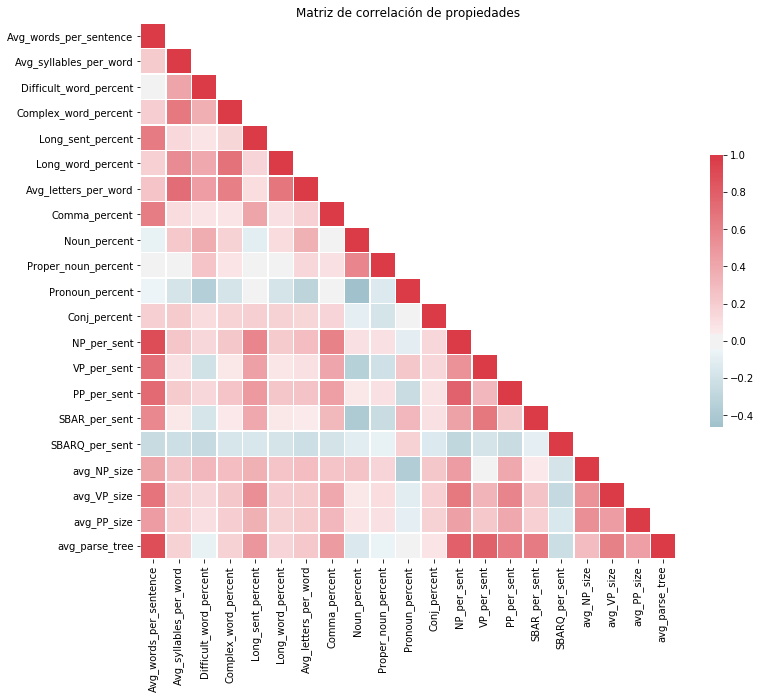

In [8]:

df_corr = df.drop(columns=['Text', 'Level'])
corr = df_corr.corr(method='spearman')

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
mask[np.diag_indices_from(mask)] = False

f, ax = plt.subplots(figsize=(12, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Matriz de correlación de propiedades")
plt.show()

In [9]:
corrwith = df_corr.corrwith(df['Level'], method='spearman')
corrwith.sort_values(ascending=False)

Conj_percent              0.373837
Long_sent_percent         0.372433
Difficult_word_percent    0.359149
Long_word_percent         0.347925
PP_per_sent               0.324125
Complex_word_percent      0.303238
Avg_syllables_per_word    0.299739
avg_VP_size               0.292194
avg_NP_size               0.287712
Avg_words_per_sentence    0.282631
NP_per_sent               0.253396
SBAR_per_sent             0.213605
VP_per_sent               0.204021
avg_PP_size               0.192071
avg_parse_tree            0.187676
Avg_letters_per_word      0.159665
Comma_percent             0.107396
Pronoun_percent           0.029418
Proper_noun_percent      -0.167722
Noun_percent             -0.204098
SBARQ_per_sent           -0.283863
dtype: float64

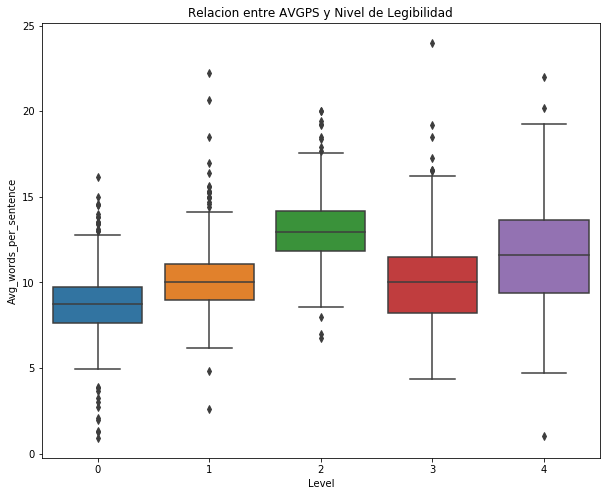

In [10]:
plt.figure(figsize=(10, 8))
sns.boxplot(x="Level", y="Avg_words_per_sentence", data=df)
plt.title("Relacion entre AVGPS y Nivel de Legibilidad")
plt.show()

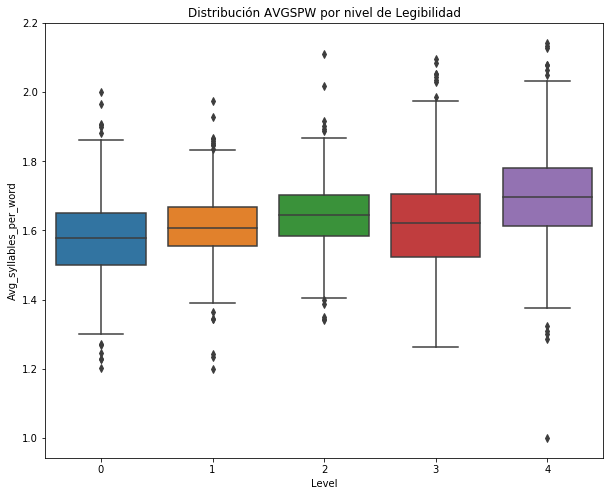

In [52]:
plt.figure(figsize=(10, 8))
sns.boxplot(x="Level", y="Avg_syllables_per_word", data=df)
plt.title("Distribución AVGSPW por nivel de Legibilidad")
plt.show()


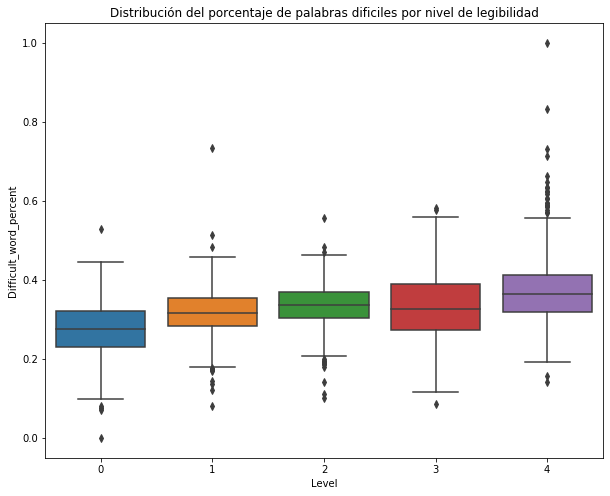

In [49]:
plt.figure(figsize=(10, 8))
sns.boxplot(x="Level", y="Difficult_word_percent", data=df)
plt.title("Distribución del porcentaje de palabras dificiles por nivel de legibilidad")
plt.show()


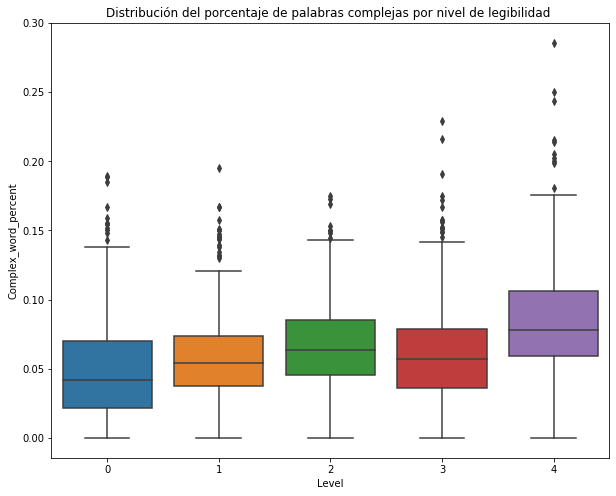

In [48]:
plt.figure(figsize=(10, 8))
sns.boxplot(x="Level", y="Complex_word_percent", data=df)
plt.title("Distribución del porcentaje de palabras complejas por nivel de legibilidad ")
plt.show()

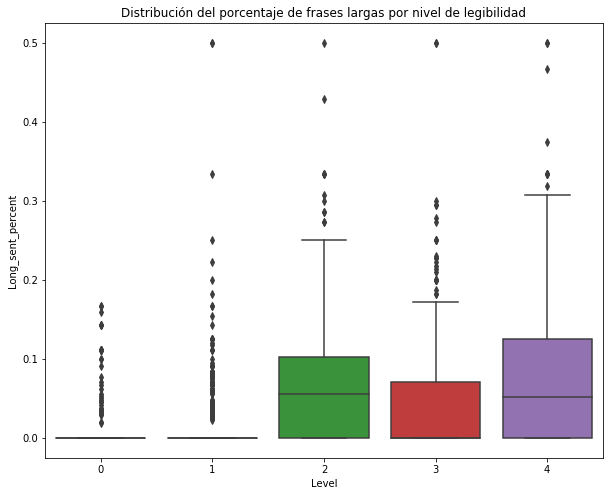

In [47]:
plt.figure(figsize=(10, 8))
sns.boxplot(x="Level", y="Long_sent_percent", data=df)
plt.title("Distribución del porcentaje de frases largas por nivel de legibilidad")
plt.show()


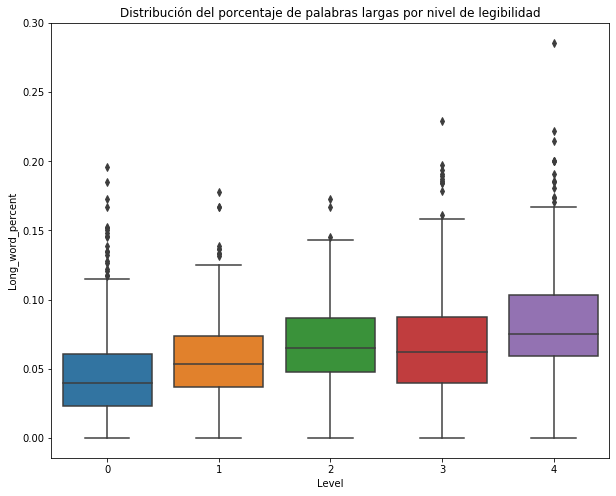

In [46]:
plt.figure(figsize=(10, 8))
sns.boxplot(x="Level", y="Long_word_percent", data=df)
plt.title("Distribución del porcentaje de palabras largas por nivel de legibilidad")
plt.show()


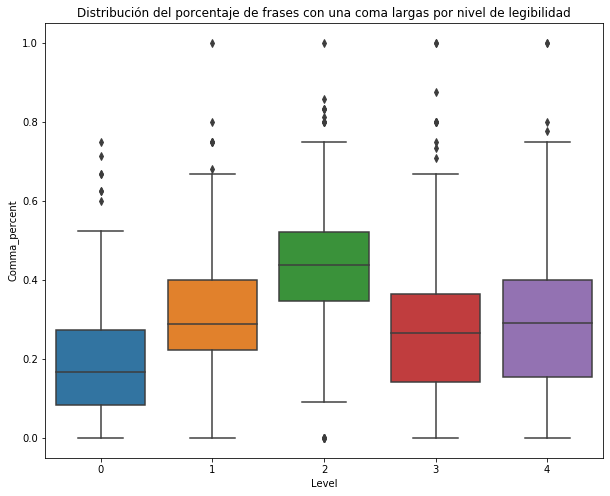

In [45]:
plt.figure(figsize=(10, 8))
sns.boxplot(x="Level", y="Comma_percent", data=df)
plt.title("Distribución del porcentaje de frases con una coma largas por nivel de legibilidad")
plt.show()

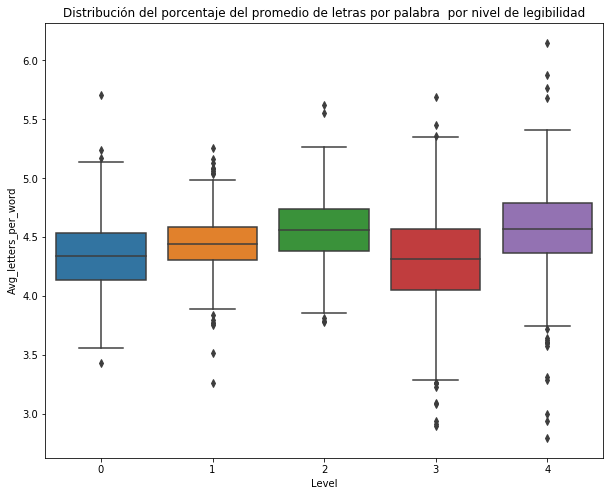

In [44]:
plt.figure(figsize=(10, 8))
sns.boxplot(x="Level", y="Avg_letters_per_word", data=df)
plt.title("Distribución del porcentaje del promedio de letras por palabra  por nivel de legibilidad")
plt.show()

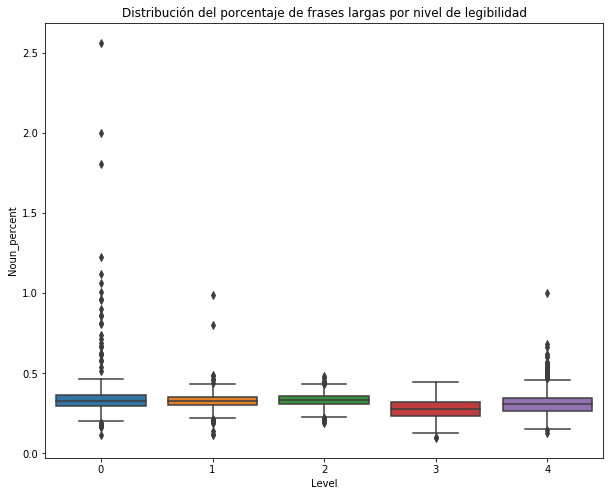

In [43]:
plt.figure(figsize=(10, 8))
sns.boxplot(x="Level", y="Noun_percent", data=df)
plt.title("Distribución del porcentaje de frases largas por nivel de legibilidad")
plt.show()

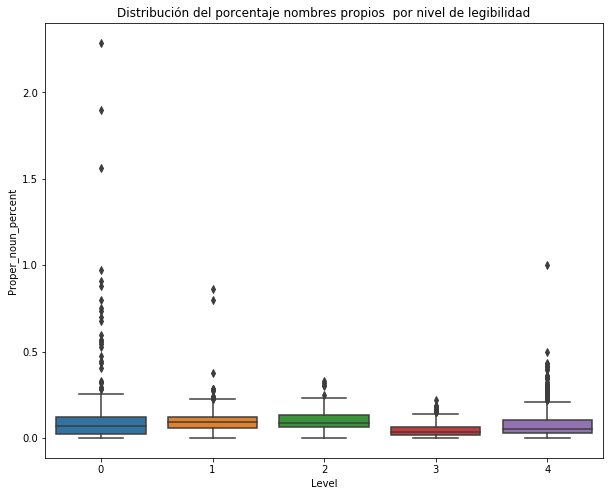

In [42]:
plt.figure(figsize=(10, 8))
sns.boxplot(x="Level", y="Proper_noun_percent", data=df)
plt.title("Distribución del porcentaje nombres propios  por nivel de legibilidad")
plt.show()


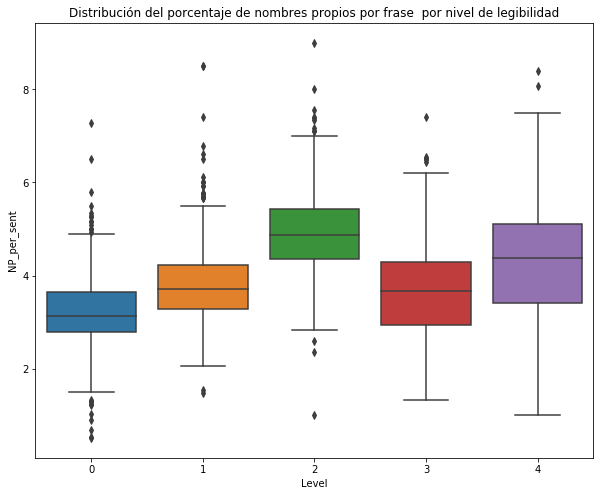

In [41]:
plt.figure(figsize=(10, 8))
sns.boxplot(x="Level", y="NP_per_sent", data=df)
plt.title("Distribución del porcentaje de nombres propios por frase  por nivel de legibilidad")
plt.show()


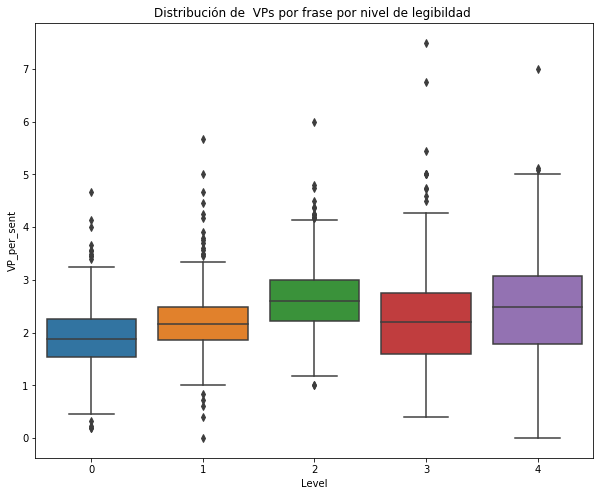

In [39]:
plt.figure(figsize=(10, 8))
sns.boxplot(x="Level", y="VP_per_sent", data=df)
plt.title("Distribución de  VPs por frase por nivel de legibildad ")
plt.show()

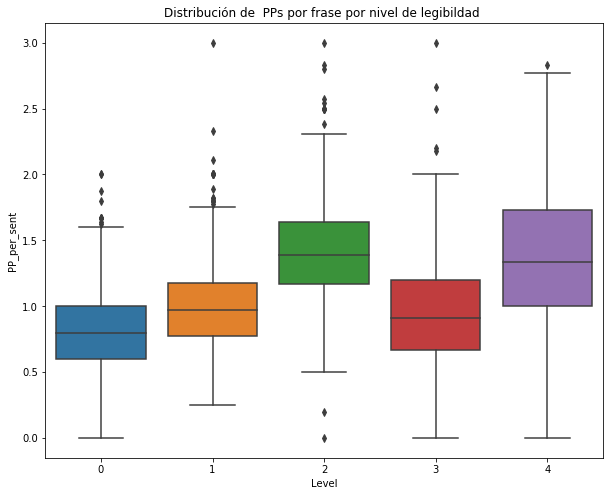

In [38]:
plt.figure(figsize=(10, 8))
sns.boxplot(x="Level", y="PP_per_sent", data=df)
plt.title("Distribución de  PPs por frase por nivel de legibildad ")
plt.show()

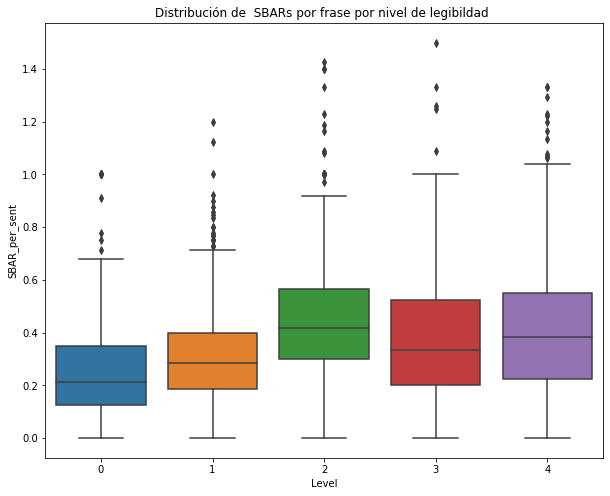

In [37]:
plt.figure(figsize=(10, 8))
sns.boxplot(x="Level", y="SBAR_per_sent", data=df)
plt.title("Distribución de  SBARs por frase por nivel de legibildad ")
plt.show()

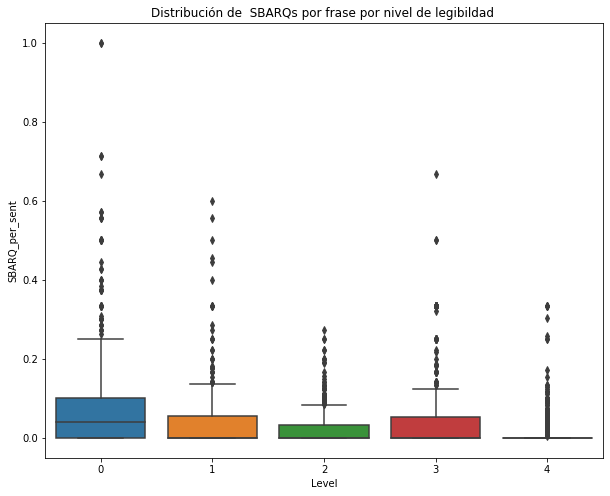

In [36]:
plt.figure(figsize=(10, 8))
sns.boxplot(x="Level", y="SBARQ_per_sent", data=df)
plt.title("Distribución de  SBARQs por frase por nivel de legibildad ")
plt.show()

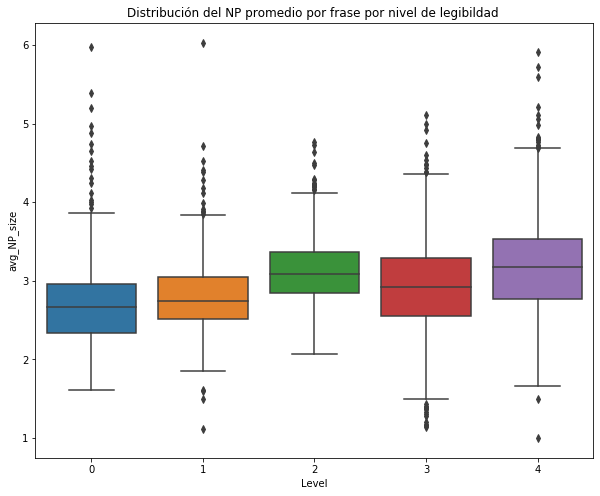

In [35]:
plt.figure(figsize=(10, 8))
sns.boxplot(x="Level", y="avg_NP_size", data=df)
plt.title("Distribución del NP promedio por frase por nivel de legibildad ")
plt.show()

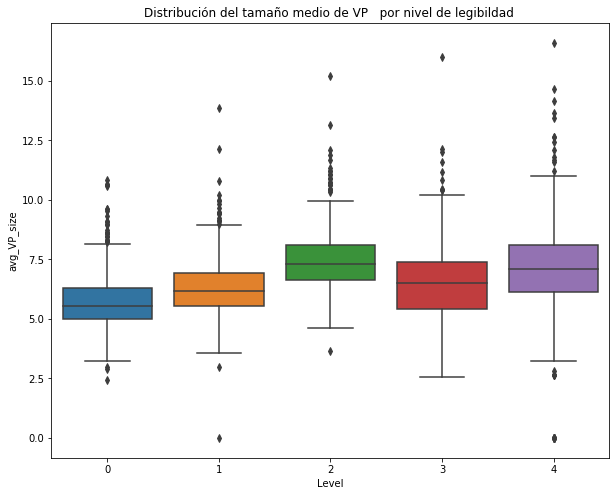

In [34]:
plt.figure(figsize=(10, 8))
sns.boxplot(x="Level", y="avg_VP_size", data=df)
plt.title("Distribución del tamaño medio de VP   por nivel de legibildad ")
plt.show()

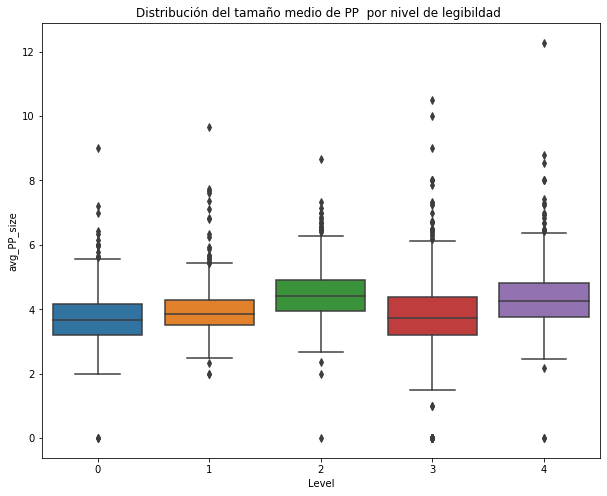

In [33]:
plt.figure(figsize=(10, 8))
sns.boxplot(x="Level", y="avg_PP_size", data=df)
plt.title("Distribución del tamaño medio de PP  por nivel de legibildad ")
plt.show()

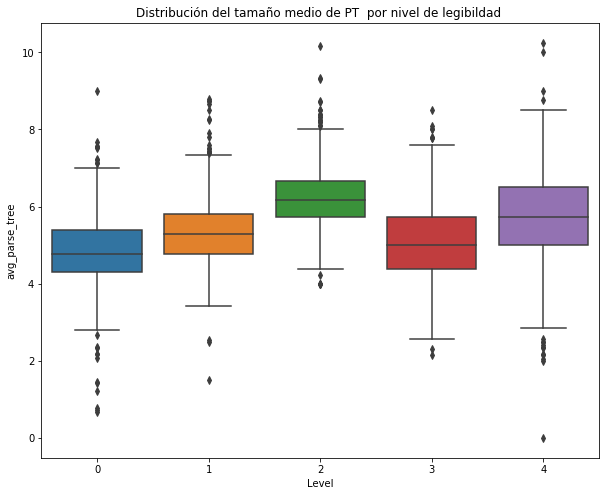

In [32]:
plt.figure(figsize=(10, 8))
sns.boxplot(x="Level", y="avg_parse_tree", data=df)
plt.title("Distribución del tamaño medio de PT  por nivel de legibildad ")
plt.show()


In [53]:
df = pd.read_csv("weebit_test.csv", index_col = 0)
df['Text'] = df['Text'].astype(str)


df = words_and_sentences(df)
df = syllables(df)
df = difficult_words_pct(df)
df = polysyllables(df)
df = complex_words_pct(df)
df = long_sent_pct(df)
df = long_word_pct(df)
df = avg_letters_per_word(df)
df = comma_pct(df)
df = pos_features(df)
df = remove_aux_features(df)


df = parse_tree_features(df)

df.to_csv("weebit_test_with_features.csv", encoding='utf-8')

C:\Users\susi0\anaconda3\lib\site-packages\torch\distributions\distribution.py:46: UserWarning: <class 'torch_struct.distributions.TreeCRF'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  'with `validate_args=False` to turn off validation.')
